## Shroomify testrun

In [ ]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
import pandas as pd

In [ ]:
import os
from pathlib import Path

# from fastai.vision import *
# kan kita pake tensorflow

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#!kaggle datasets download -d maysee/mushrooms-classification-common-genuss-images
!kaggle datasets download -d mustai/mushroom-12-9528

100% 1.32G/1.33G [00:51<00:00, 33.0MB/s]
100% 1.33G/1.33G [00:51<00:00, 27.6MB/s]


In [ ]:
import zipfile
#local_zip = '/content/mushrooms-classification-common-genuss-images.zip'
local_zip = '/content/mushroom-12-9528.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/mushroom-dataset-2')
zip_ref.close()

In [ ]:
# Assign training and validation set directories
base_dir = '/content/mushroom-dataset-2/Mushrooms_3dataset(9528)'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'valid')

In [ ]:
train_agaricus_dir = os.path.join(train_dir, 'Agaricus')
test_agaricus_dir = os.path.join(test_dir, 'Agaricus')
validation_agaricus_dir = os.path.join(validation_dir, 'Agaricus')

train_amanita_dir = os.path.join(train_dir, 'Amanita')
test_amanita_dir = os.path.join(test_dir, 'Amanita')
validation_amanita_dir = os.path.join(validation_dir, 'Amanita')

In [ ]:
train_agaricus_fnames = os.listdir( train_agaricus_dir )
train_amanita_fnames = os.listdir( train_amanita_dir )

print(train_agaricus_fnames[:10])
print(train_amanita_fnames[:10])

['TOB2015PIC58826914.JPG', 'TL2015PIC86744804(1).jpg', 'BWP2017-9201424_SJbHErgrP-(1).jpg', 'TS2014PIC68829831.jpg', 'RF2016-9167262_S1bgBZVgw.JPG', '181_42srgvDitnE.jpg', '436_9tRek5ZiV6E.jpg', '119_D_g33HPgXp4.jpg', '005_sUqyy4Yb9VY.jpg', '406_6DHzPhxyghE.jpg']
['039_ukO5iaLSiRM.jpg', '118_ooKU3s1k04I.jpg', '403_jNYtLAREMbE.jpg', '665_PrGfCOsVu8Y.jpg', '240_6MwHQ8jRclQ.jpg', '085_3LW6CG33oSQ.jpg', '648_Ykrh4cUrXQo.jpg', '782_fqegXGS2jxM.jpg', '071_SDRvTCrFXG8.jpg', '524_VsVRzUaXfpQ.jpg']


In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

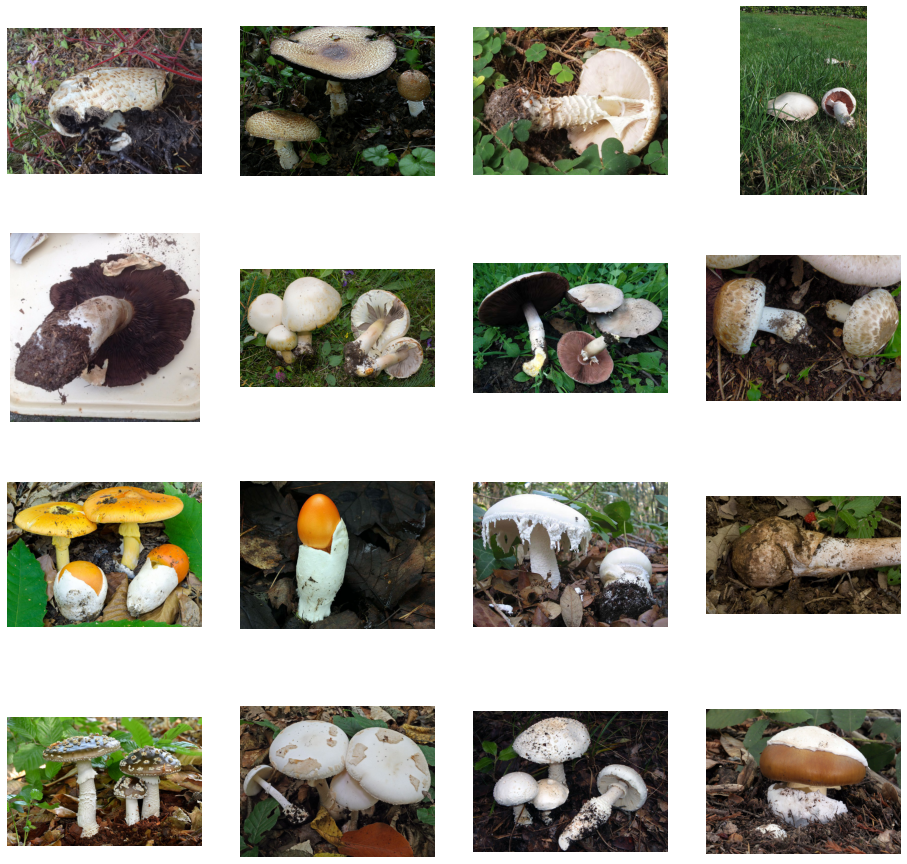

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_agaricus_dir, fname) 
                for fname in train_agaricus_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_amanita_dir, fname) 
                for fname in train_amanita_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [ ]:
# Build the model
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(12, activation='softmax')
])

In [ ]:
from tensorflow.keras.optimizers import Adam

# Set training parameters
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Apply data augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow training images in batches of 128 using train_datagen generator
# test_generator = validation_datagen.flow_from_directory(
#         test_dir,  # This is the source directory for training images
#         target_size=(150, 150),  # All images will be resized to 150x150
#         batch_size=32,
#         # Since we use binary_crossentropy loss, we need binary labels
#         class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

Found 6664 images belonging to 12 classes.
Found 953 images belonging to 12 classes.


In [ ]:
# Constant for epochs
EPOCHS = 50

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=52.0625,  
      epochs=EPOCHS,
      verbose=2,
      validation_data = validation_generator,
      validation_steps=29.78125)

Epoch 1/50
52/52 - 627s - loss: 2.3858 - accuracy: 0.1591 - val_loss: 2.3365 - val_accuracy: 0.1763 - 627s/epoch - 12s/step
Epoch 2/50
52/52 - 617s - loss: 2.2649 - accuracy: 0.2131 - val_loss: 2.2581 - val_accuracy: 0.2099 - 617s/epoch - 12s/step
Epoch 3/50
52/52 - 619s - loss: 2.1844 - accuracy: 0.2486 - val_loss: 2.2165 - val_accuracy: 0.2686 - 619s/epoch - 12s/step
Epoch 4/50
52/52 - 625s - loss: 2.1372 - accuracy: 0.2656 - val_loss: 2.2101 - val_accuracy: 0.2413 - 625s/epoch - 12s/step
Epoch 5/50
52/52 - 630s - loss: 2.1044 - accuracy: 0.2781 - val_loss: 2.2046 - val_accuracy: 0.2613 - 630s/epoch - 12s/step
Epoch 6/50
52/52 - 636s - loss: 2.0780 - accuracy: 0.2863 - val_loss: 2.2130 - val_accuracy: 0.2581 - 636s/epoch - 12s/step
Epoch 7/50
52/52 - 621s - loss: 2.0503 - accuracy: 0.3009 - val_loss: 2.2117 - val_accuracy: 0.2571 - 621s/epoch - 12s/step
Epoch 8/50
52/52 - 628s - loss: 2.0279 - accuracy: 0.3112 - val_loss: 2.2398 - val_accuracy: 0.2602 - 628s/epoch - 12s/step
Epoch 9/

## Parse Data Input

In [ ]:
def parse_data_from_input(filename):
  with open(filename) as file:
    ### START CODE HERE

    # Use csv.reader, passing in the appropriate delimiter
    # Remember that csv.reader can be iterated and returns one line in each iteration
    csv_reader = csv.reader(file, delimiter=',')
    
    labels = []
    images = []
    
    next(csv_reader, None)

    for row in csv_reader:
      
      label = row[0]
      image = row[1:]
      image = np.reshape(image, (28, 28, 1))

      labels.append(label)
      images.append(image)

    labels = np.array(labels).astype('float')
    images = np.array(images).astype('float')


    return images, labels

In [ ]:
# Test your function
training_images, training_labels = parse_data_from_input('/content/mushrooms.csv')
#validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape}")
print(f"Training labels has shape: {training_labels.shape}")
#print(f"Validation images has shape: {validation_images.shape}")
#print(f"Validation labels has shape: {validation_labels.shape}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = Path.home() / '/content/drive/My Drive/repos_github/mushroom-identifier/data'
google_path = data_path / 'google'

In [ ]:
csv_folder = google_path / 'csv'
raw_folder = google_path / 'raw_images'

## Load Mushroom Info

In [ ]:
df_mushrooms = pd.read_excel(data_path / 'mushrooms.xlsx', index_col=0)
df_mushrooms.set_index('Index', inplace=True, drop=True)
df_mushrooms.head()

In [ ]:
import glob

all_files = glob.glob('/content/drive/MyDrive/repos_github/mushroom-identifier/data/google/csv/*.csv')
df = pd.concat((pd.read_csv(f, on_bad_lines='skip') for f in all_files))
df

In [ ]:
with open('/content/drive/MyDrive/repos_github/mushroom-identifier/data/google/csv/Amanita_Citrina.csv') as filee:
  print(filee.readline())

https://www.first-nature.com/fungi/images/amanitaceae/amanita-citrina6.jpg



In [ ]:
# assuming a csv file with a name in column 0 and the image url in column 1
import os
import urllib
import time

def save_image_from_csv(filename, path_to_save):

  # open file to read
  with open("{0}".format(filename), 'r') as csvfile:
      # iterate on all lines
      i = 0
      
      for line in csvfile:
          splitted_line = line.split(',')
          fullfilepath = os.path.join(path_to_save, "img_" + str(i) + ".jpg")
          # check if we have an image URL
          try:
            if splitted_line[0] != '' and splitted_line[0] != "\n":
                urllib.request.urlretrieve(splitted_line[0], fullfilepath)
                print("Image saved for {0}".format(splitted_line[0]))
                i += 1
                #time.sleep(3)
            else:
                print("No result for {0}".format(splitted_line[0]))
          except:
            continue

directory = "/content/drive/MyDrive/repos_github/mushroom-identifier/data/google/csv/"
raw_dir = "/content/drive/MyDrive/repos_github/mushroom-identifier/data/google/raw_images/"


# a = "/content/drive/MyDrive/repos_github/mushroom-identifier/data/google/csv/Amanita Vaginata.csv"
# b = "/content/drive/MyDrive/repos_github/mushroom-identifier/data/google/raw_images/Amanita Vaginata"
for files in os.scandir(directory):
    base_file = os.path.basename(files.path)
    base_dir = os.path.splitext(base_file)[0]
    csv_path = directory + base_file
    raw_path = raw_dir + base_dir
    if files.is_file():
      save_image_from_csv(csv_path,raw_path)